# Caching Analysis

## reading csv files

In [1]:
import os
import pandas as pd

folder_path = "../exp/csv"


dataframes = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_path, filename))
        dataframes[filename] = df

# Print the dataframes for each file
for filename, df in dataframes.items():
    print(f"Dataframe for {filename}:")
    print(df)
    


Dataframe for Fifo-7500-1000000-638123439580317946.csv:
        Approved          ArrivalTime        DepartureTime  \
0           True  18/02/2023 18:59:20  18/02/2023 18:59:20   
1           True  18/02/2023 18:59:20  18/02/2023 18:59:20   
2           True  18/02/2023 18:59:20  18/02/2023 18:59:20   
3           True  18/02/2023 18:59:20  18/02/2023 18:59:20   
4           True  18/02/2023 18:59:20  18/02/2023 18:59:20   
...          ...                  ...                  ...   
999995      True  18/02/2023 19:05:57  18/02/2023 19:05:57   
999996      True  18/02/2023 19:05:57  18/02/2023 19:05:57   
999997      True  18/02/2023 19:05:57  18/02/2023 19:05:57   
999998      True  18/02/2023 19:05:57  18/02/2023 19:05:57   
999999     False  18/02/2023 19:05:57  18/02/2023 19:05:57   

        TimeElapsedInNanosseconds  CacheHit  
0                           79400     False  
1                            7400     False  
2                            5300     False  
3              

## removing unnecessary data

In [2]:
for filename, df in dataframes.items():
    dataframes[filename] = df.drop(columns=['Approved','ArrivalTime', 'DepartureTime'])

## categoryzing test scenarios

In [3]:
class TestScenario:
    def __init__(self, filename, df):
        parts = filename.split('-')
        self.strategy = parts[0]
        self.cache_size = parts[1]
        self.requests_number = parts[2]
        self.requests = df
    def __str__(self):
        return f"strategy: {self.strategy} cache_size: {self.cache_size} requests_number: {self.requests_number}"

In [4]:
scenarios = []
for filename, df in dataframes.items():
    scenario = TestScenario(filename, df)
    print(scenario)
    scenarios.append(scenario)

strategy: Fifo cache_size: 7500 requests_number: 1000000
strategy: LFU cache_size: 2500 requests_number: 1000000
strategy: Only cache_size: 10000 requests_number: 1000000
strategy: Fifo cache_size: 2500 requests_number: 1000000
strategy: Fifo cache_size: 5000 requests_number: 1000000
strategy: LFU cache_size: 7500 requests_number: 1000000
strategy: LFU cache_size: 5000 requests_number: 1000000
strategy: None cache_size: 0 requests_number: 1000000


In [5]:
for scenario in scenarios:
    print(scenario.requests)

        TimeElapsedInNanosseconds  CacheHit
0                           79400     False
1                            7400     False
2                            5300     False
3                            5200     False
4                            4600     False
...                           ...       ...
999995                          0      True
999996                          0      True
999997                       5600     False
999998                          0      True
999999                       5200     False

[1000000 rows x 2 columns]
        TimeElapsedInNanosseconds  CacheHit
0                            7800     False
1                            5000     False
2                            4900     False
3                            4300     False
4                            4000     False
...                           ...       ...
999995                          0      True
999996                          0      True
999997                          0      True
9999

In [6]:
strategies = []
sizes = []

def get_distinct(_list):
    distinct = list(set(_list))
    return distinct

for scenario in scenarios:
    strategies.append(scenario.strategy)
    sizes.append(scenario.cache_size)

In [7]:
scenariosDict = {}

for strategy in strategies:
    scenariosDict[strategy] = {} 

for scenario in scenarios:
    scenariosDict[scenario.strategy][scenario.cache_size]= scenario

In [8]:
print(scenariosDict['Fifo']['7500'].requests)

        TimeElapsedInNanosseconds  CacheHit
0                           79400     False
1                            7400     False
2                            5300     False
3                            5200     False
4                            4600     False
...                           ...       ...
999995                          0      True
999996                          0      True
999997                       5600     False
999998                          0      True
999999                       5200     False

[1000000 rows x 2 columns]


## gráficos de tempo de serviço por estratégia

### Baseline (RDB)

range(1, 1000001)


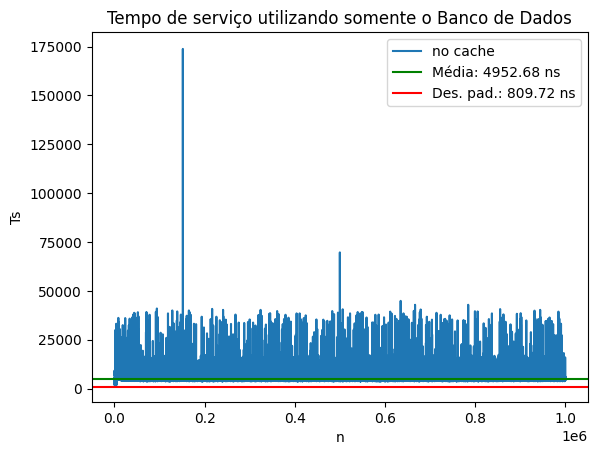

In [9]:
import matplotlib.pyplot as plt
import numpy as np

nRequests = 1000000
n = range(1, nRequests+1)
print(n)
serviceTime = 'TimeElapsedInNanosseconds'

RDB = scenariosDict['None']['0'].requests[serviceTime]



fig, ax = plt.subplots()

MtsRDB = np.mean(RDB)
mtsRDBstd = np.std(RDB)


ax.plot(n, RDB, label='no cache')
ax.axhline(MtsRDB, color='green', label=f'Média: {MtsRDB:.2f} ns')

ax.axhline(mtsRDBstd, color='red', label=f'Des. pad.: {mtsRDBstd:.2f} ns')

ax.legend()

ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title('Tempo de serviço utilizando somente o Banco de Dados')


plt.savefig("graphs/Tempo de serviço utilizando somente o Banco de Dados.svg", format="svg")
plt.show()


### Baseline (Cache Only)

range(1, 1000001)


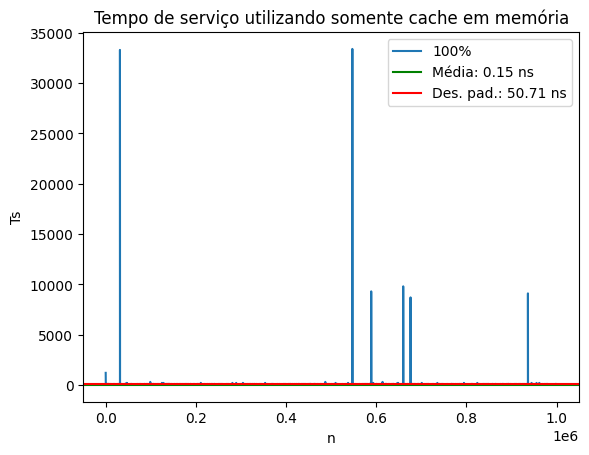

In [11]:
import matplotlib.pyplot as plt
import numpy as np

nRequests = 1000000
n = range(1, nRequests+1)
print(n)
serviceTime = 'TimeElapsedInNanosseconds'

OnlyCache = scenariosDict['Only']['10000'].requests[serviceTime]



fig, ax = plt.subplots()

MtsOnlyCache = np.mean(OnlyCache)
mtsOnlyCachestd = np.std(OnlyCache)


ax.plot(n, OnlyCache, label='100%')
ax.axhline(MtsOnlyCache, color='green', label=f'Média: {MtsOnlyCache:.2f} ns')

ax.axhline(mtsOnlyCachestd, color='red', label=f'Des. pad.: {mtsOnlyCachestd:.2f} ns')

ax.legend()

graphName = 'Tempo de serviço utilizando somente cache em memória'

ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)


plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

### Fifo

range(1, 1000001)


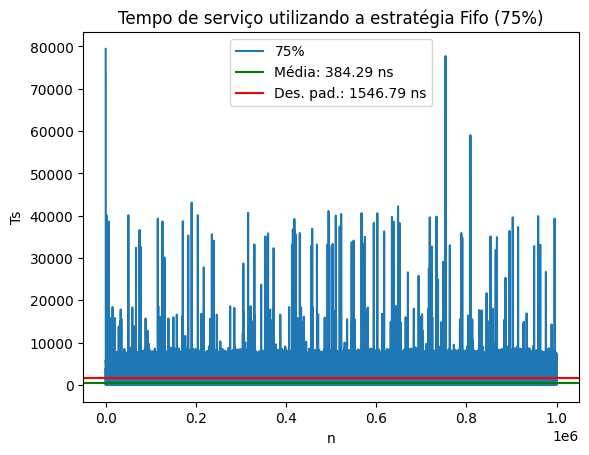

In [12]:
import matplotlib.pyplot as plt
import numpy as np

nRequests = 1000000
n = range(1, nRequests+1)
print(n)
serviceTime = 'TimeElapsedInNanosseconds'

Fifo_75p = scenariosDict['Fifo']['7500'].requests[serviceTime]
Fifo_50p = scenariosDict['Fifo']['5000'].requests[serviceTime]
Fifo_25p = scenariosDict['Fifo']['2500'].requests[serviceTime]



fig, ax = plt.subplots()

Mts75p = np.mean(Fifo_75p)
mts75std = np.std(Fifo_75p)


ax.plot(n, Fifo_75p, label='75%')
ax.axhline(Mts75p, color='green', label=f'Média: {Mts75p:.2f} ns')

ax.axhline(mts75std, color='red', label=f'Des. pad.: {mts75std:.2f} ns')

ax.legend()

graphName = 'Tempo de serviço utilizando a estratégia Fifo (75%)'

ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

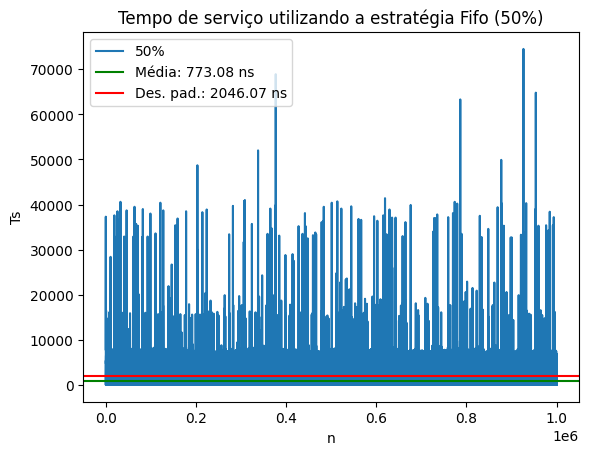

In [13]:
fig, ax = plt.subplots()

Mts50p = np.mean(Fifo_50p)
mts50std = np.std(Fifo_50p)


ax.plot(n, Fifo_50p, label='50%')
ax.axhline(Mts50p, color='green', label=f'Média: {Mts50p:.2f} ns')

ax.axhline(mts50std, color='red', label=f'Des. pad.: {mts50std:.2f} ns')

ax.legend()
graphName = 'Tempo de serviço utilizando a estratégia Fifo (50%)'

ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

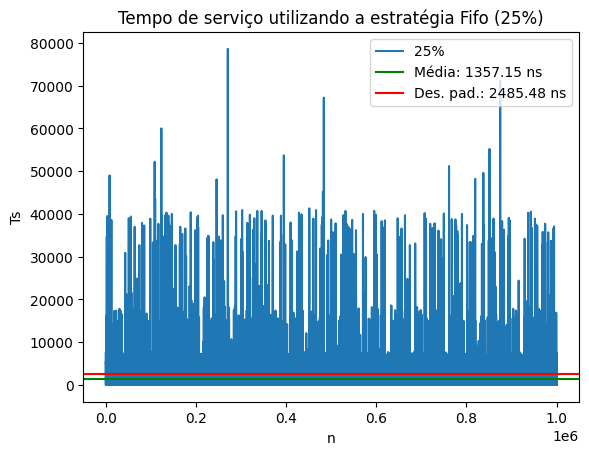

In [14]:
fig, ax = plt.subplots()

Mts25p = np.mean(Fifo_25p)
mts25std = np.std(Fifo_25p)


ax.plot(n, Fifo_25p, label='25%')
ax.axhline(Mts25p, color='green', label=f'Média: {Mts25p:.2f} ns')

ax.axhline(mts25std, color='red', label=f'Des. pad.: {mts25std:.2f} ns')

ax.legend()

graphName = 'Tempo de serviço utilizando a estratégia Fifo (25%)'
ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)


plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

#### média móvel

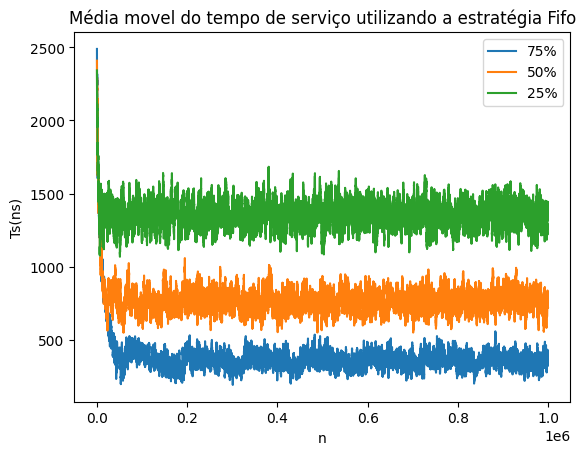

In [15]:
window_size = 1000
weights = np.repeat(1.0, window_size) / window_size


Fifo_75pmm = np.convolve(Fifo_75p, weights, 'valid')
Fifo_50pmm = np.convolve(Fifo_50p, weights, 'valid')
Fifo_25pmm = np.convolve(Fifo_25p, weights, 'valid')
RDBmm = np.convolve(RDB, weights, 'valid')
OnlyCachemm = np.convolve(OnlyCache, weights, 'valid')

nmm = range(1, len(Fifo_75pmm)+1)

fig, ax = plt.subplots()

ax.plot(nmm, Fifo_75pmm, label='75%')
ax.plot(nmm, Fifo_50pmm, label='50%')
ax.plot(nmm, Fifo_25pmm, label='25%')
    
ax.legend()

graphName = 'Média movel do tempo de serviço utilizando a estratégia Fifo'

ax.set_xlabel('n')
ax.set_ylabel('Ts(ns)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

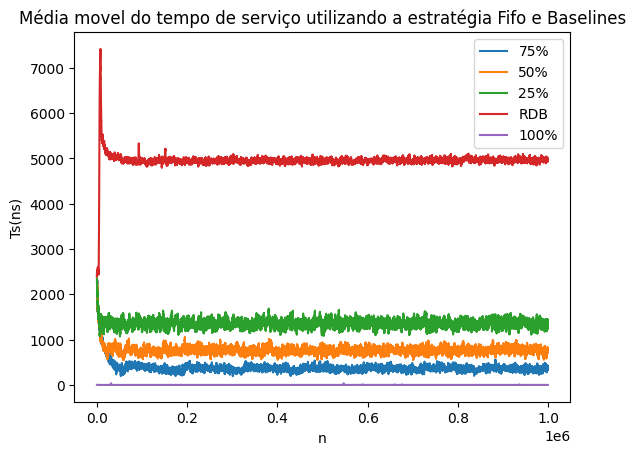

In [16]:
fig, ax = plt.subplots()

ax.plot(nmm, Fifo_75pmm, label='75%')
ax.plot(nmm, Fifo_50pmm, label='50%')
ax.plot(nmm, Fifo_25pmm, label='25%')
ax.plot(nmm, RDBmm, label='RDB')
ax.plot(nmm, OnlyCachemm, label='100%')
    
ax.legend()

graphName = 'Média movel do tempo de serviço utilizando a estratégia Fifo e Baselines'

ax.set_xlabel('n')
ax.set_ylabel('Ts(ns)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

### LFU

range(1, 1000001)


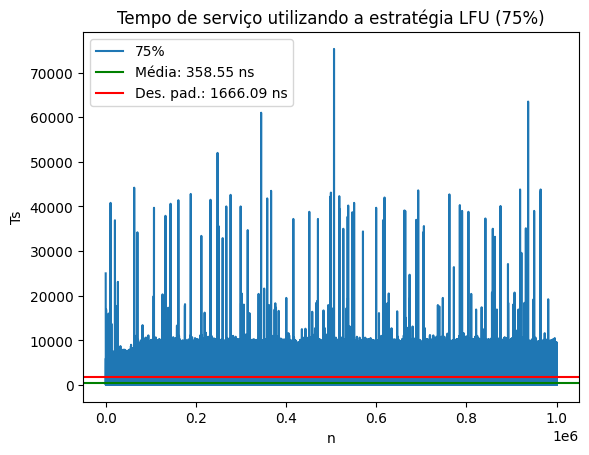

In [17]:


nRequests = 1000000
n = range(1, nRequests+1)
print(n)
serviceTime = 'TimeElapsedInNanosseconds'

LFU_75p = scenariosDict['LFU']['7500'].requests[serviceTime]
LFU_50p = scenariosDict['LFU']['5000'].requests[serviceTime]
LFU_25p = scenariosDict['LFU']['2500'].requests[serviceTime]



fig, ax = plt.subplots()

Mts75p = np.mean(LFU_75p)
mts75std = np.std(LFU_75p)


ax.plot(n, LFU_75p, label='75%')
ax.axhline(Mts75p, color='green', label=f'Média: {Mts75p:.2f} ns')

ax.axhline(mts75std, color='red', label=f'Des. pad.: {mts75std:.2f} ns')

ax.legend()
graphName = 'Tempo de serviço utilizando a estratégia LFU (75%)'
ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

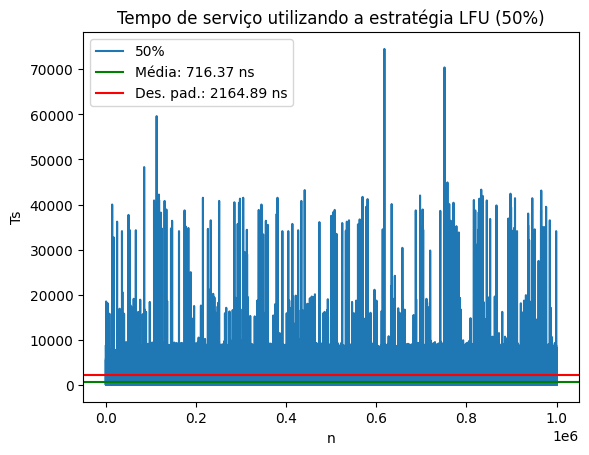

In [18]:
fig, ax = plt.subplots()

Mts50p = np.mean(LFU_50p)
mts50std = np.std(LFU_50p)


ax.plot(n, LFU_50p, label='50%')
ax.axhline(Mts50p, color='green', label=f'Média: {Mts50p:.2f} ns')

ax.axhline(mts50std, color='red', label=f'Des. pad.: {mts50std:.2f} ns')

ax.legend()
graphName = 'Tempo de serviço utilizando a estratégia LFU (50%)'

ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

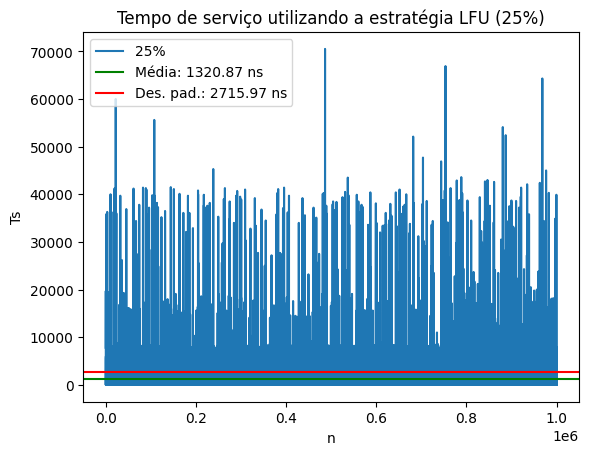

In [19]:
fig, ax = plt.subplots()

Mts25p = np.mean(LFU_25p)
mts25std = np.std(LFU_25p)


ax.plot(n, LFU_25p, label='25%')
ax.axhline(Mts25p, color='green', label=f'Média: {Mts25p:.2f} ns')

ax.axhline(mts25std, color='red', label=f'Des. pad.: {mts25std:.2f} ns')

ax.legend()

graphName = 'Tempo de serviço utilizando a estratégia LFU (25%)'
ax.set_xlabel('n')
ax.set_ylabel('Ts')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

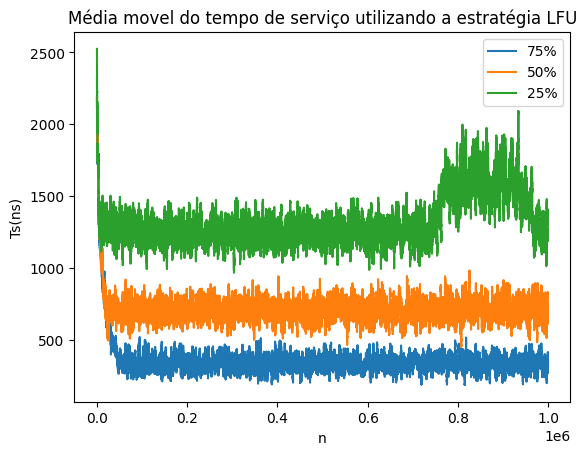

In [20]:
window_size = 1000
weights = np.repeat(1.0, window_size) / window_size


LFU_75pmm = np.convolve(LFU_75p, weights, 'valid')
LFU_50pmm = np.convolve(LFU_50p, weights, 'valid')
LFU_25pmm = np.convolve(LFU_25p, weights, 'valid')
RDBmm = np.convolve(RDB, weights, 'valid')
OnlyCachemm = np.convolve(OnlyCache, weights, 'valid')

nmm = range(1, len(LFU_75pmm)+1)

fig, ax = plt.subplots()

ax.plot(nmm, LFU_75pmm, label='75%')
ax.plot(nmm, LFU_50pmm, label='50%')
ax.plot(nmm, LFU_25pmm, label='25%')
    
ax.legend()

graphName = 'Média movel do tempo de serviço utilizando a estratégia LFU'

ax.set_xlabel('n')
ax.set_ylabel('Ts(ns)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

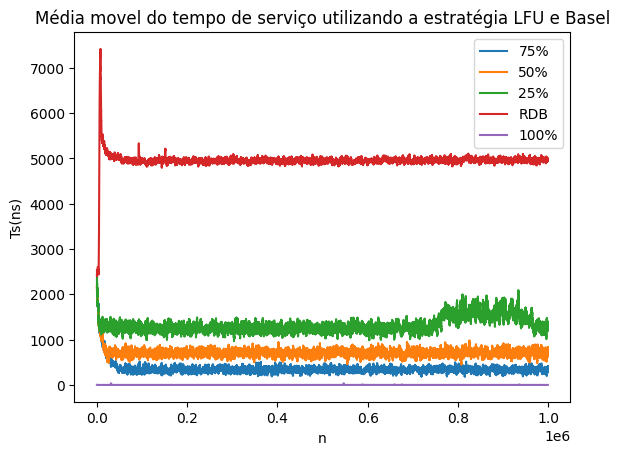

In [21]:
fig, ax = plt.subplots()

ax.plot(nmm, LFU_75pmm, label='75%')
ax.plot(nmm, LFU_50pmm, label='50%')
ax.plot(nmm, LFU_25pmm, label='25%')
ax.plot(nmm, RDBmm, label='RDB')
ax.plot(nmm, OnlyCachemm, label='100%')
    
ax.legend()

graphName = 'Média movel do tempo de serviço utilizando a estratégia LFU e Basel'

ax.set_xlabel('n')
ax.set_ylabel('Ts(ns)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

## Gráficos de Hit Rate (Hr) por estratégia

### Fifo

In [22]:
def cumulative_sum(arr):
    cum_sum = [0] * len(arr)
    cum_sum[0] = arr[0]

    for i in range(1, len(arr)):
        cum_sum[i] = cum_sum[i - 1] + arr[i]

    return cum_sum

def rate(arr):
    n_arr = [0] * len(arr)
    n_arr[0] = arr[0]
    
    for i in range(1, len(arr)):
        n_arr[i] = (arr[i]/i)*100
    
    return n_arr

def cumulative_rate(arr):
    return rate(cumulative_sum(arr))

In [23]:
import matplotlib.pyplot as plt
import numpy as np

nRequests = 1000000
n = range(1, nRequests+1)

cacheHit = 'CacheHit'

Fifo_75p = cumulative_rate(scenariosDict['Fifo']['7500'].requests[cacheHit].astype(int))
Fifo_50p = cumulative_rate(scenariosDict['Fifo']['5000'].requests[cacheHit].astype(int))
Fifo_25p = cumulative_rate(scenariosDict['Fifo']['2500'].requests[cacheHit].astype(int))


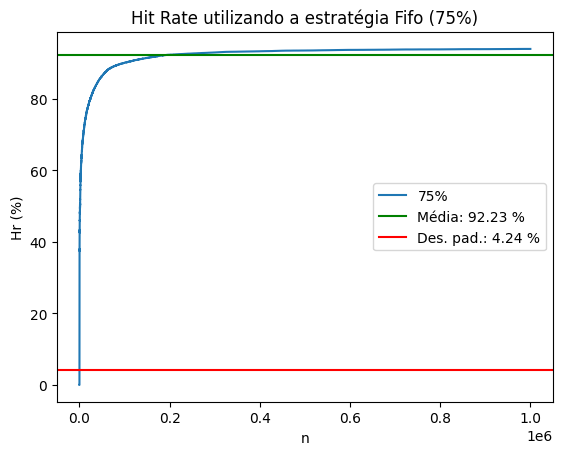

In [24]:
fig, ax = plt.subplots()

Mts75p = np.mean(Fifo_75p)
mts75std = np.std(Fifo_75p)


ax.plot(n, Fifo_75p, label='75%')

ax.axhline(Mts75p, color='green', label=f'Média: {Mts75p:.2f} %')

ax.axhline(mts75std, color='red', label=f'Des. pad.: {mts75std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia Fifo (75%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)
plt.savefig(f"graphs/{graphName}.svg", format="svg")

plt.show()

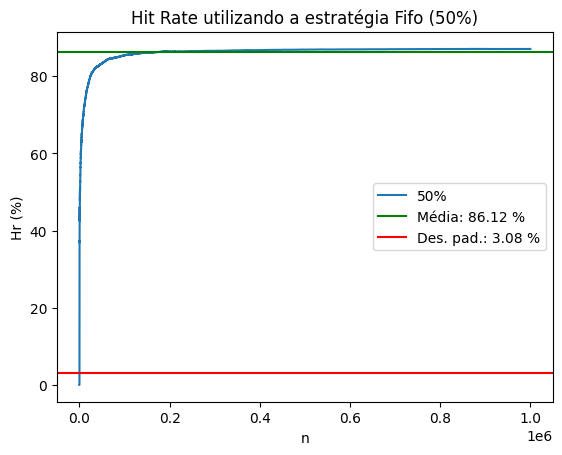

In [25]:
fig, ax = plt.subplots()

Mts50p = np.mean(Fifo_50p)
mts50std = np.std(Fifo_50p)


ax.plot(n, Fifo_50p, label='50%')

ax.axhline(Mts50p, color='green', label=f'Média: {Mts50p:.2f} %')

ax.axhline(mts50std, color='red', label=f'Des. pad.: {mts50std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia Fifo (50%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

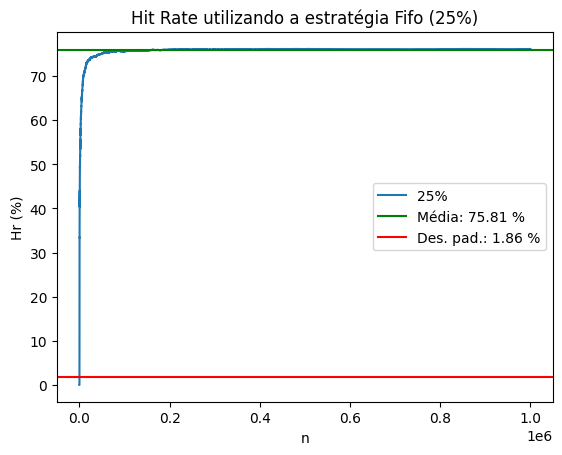

In [26]:
fig, ax = plt.subplots()

Mts25p = np.mean(Fifo_25p)
mts25std = np.std(Fifo_25p)


ax.plot(n, Fifo_25p, label='25%')

ax.axhline(Mts25p, color='green', label=f'Média: {Mts25p:.2f} %')

ax.axhline(mts25std, color='red', label=f'Des. pad.: {mts25std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia Fifo (25%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

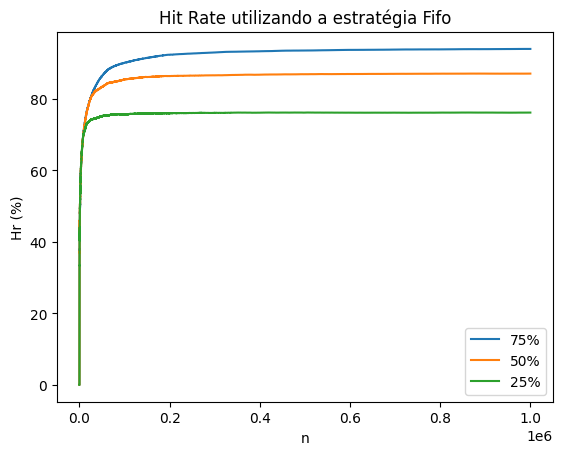

In [27]:
fig, ax = plt.subplots()


ax.plot(n, Fifo_75p, label='75%')
ax.plot(n, Fifo_50p, label='50%')
ax.plot(n, Fifo_25p, label='25%')
ax.legend()

graphName = 'Hit Rate utilizando a estratégia Fifo'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

### LFU

In [28]:
LFU_75p = cumulative_rate(scenariosDict['LFU']['7500'].requests[cacheHit].astype(int))
LFU_50p = cumulative_rate(scenariosDict['LFU']['5000'].requests[cacheHit].astype(int))
LFU_25p = cumulative_rate(scenariosDict['LFU']['2500'].requests[cacheHit].astype(int))

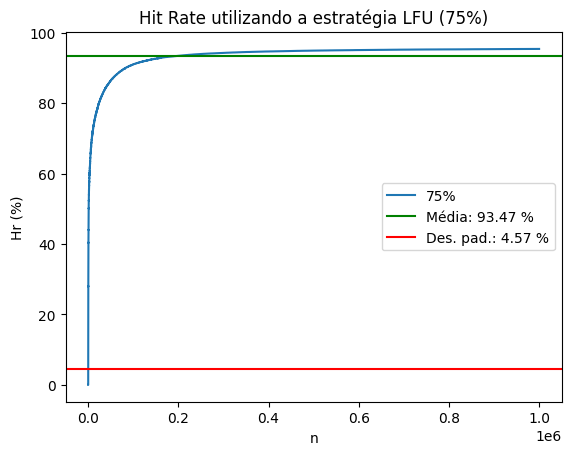

In [29]:
fig, ax = plt.subplots()

Mts75p = np.mean(LFU_75p)
mts75std = np.std(LFU_75p)


ax.plot(n, LFU_75p, label='75%')

ax.axhline(Mts75p, color='green', label=f'Média: {Mts75p:.2f} %')

ax.axhline(mts75std, color='red', label=f'Des. pad.: {mts75std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia LFU (75%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

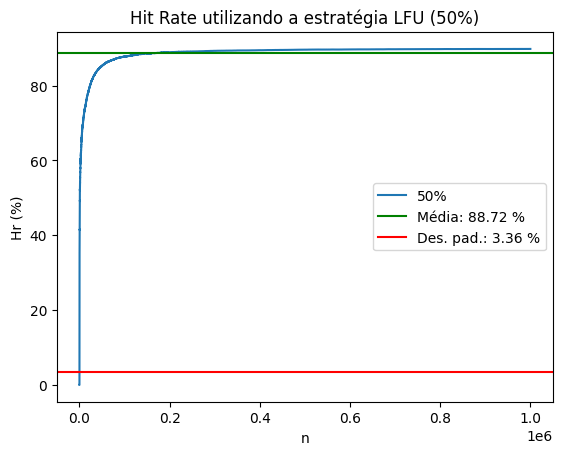

In [34]:
fig, ax = plt.subplots()

Mts50p = np.mean(LFU_50p)
mts50std = np.std(LFU_50p)


ax.plot(n, LFU_50p, label='50%')

ax.axhline(Mts50p, color='green', label=f'Média: {Mts50p:.2f} %')

ax.axhline(mts50std, color='red', label=f'Des. pad.: {mts50std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia LFU (50%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)


plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

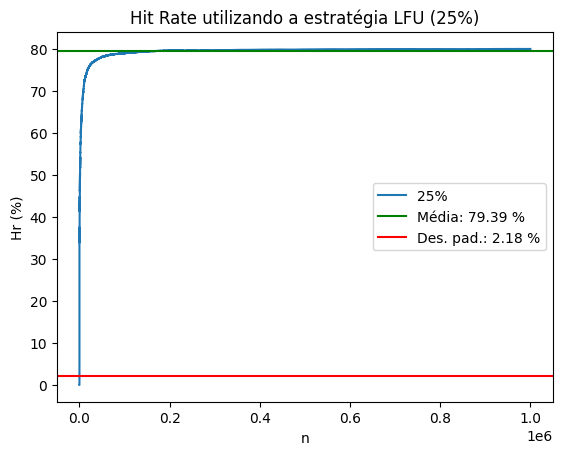

In [35]:
fig, ax = plt.subplots()

Mts25p = np.mean(LFU_25p)
mts25std = np.std(LFU_25p)


ax.plot(n, LFU_25p, label='25%')

ax.axhline(Mts25p, color='green', label=f'Média: {Mts25p:.2f} %')

ax.axhline(mts25std, color='red', label=f'Des. pad.: {mts25std:.2f} %')

ax.legend()

graphName = 'Hit Rate utilizando a estratégia LFU (25%)'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

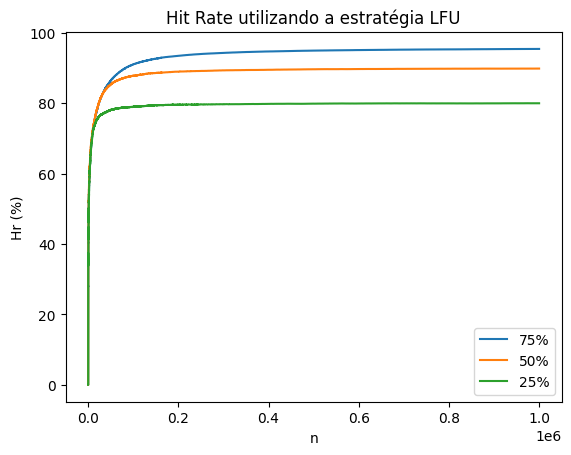

In [36]:
fig, ax = plt.subplots()


ax.plot(n, LFU_75p, label='75%')
ax.plot(n, LFU_50p, label='50%')
ax.plot(n, LFU_25p, label='25%')
ax.legend()

graphName = 'Hit Rate utilizando a estratégia LFU'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)

plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

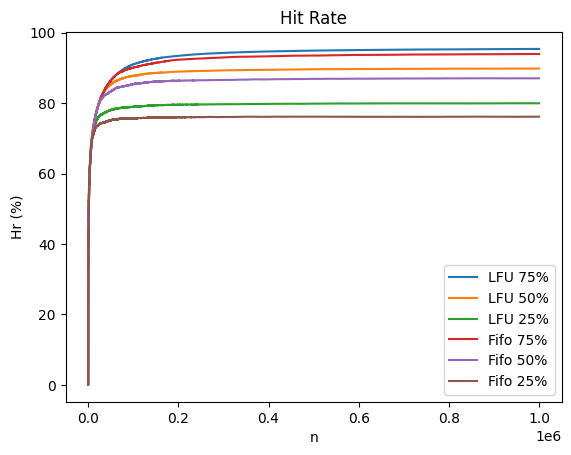

In [37]:
fig, ax = plt.subplots()


ax.plot(n, LFU_75p, label='LFU 75%')
ax.plot(n, LFU_50p, label='LFU 50%')
ax.plot(n, LFU_25p, label='LFU 25%')
ax.plot(n, Fifo_75p, label='Fifo 75%')
ax.plot(n, Fifo_50p, label='Fifo 50%')
ax.plot(n, Fifo_25p, label='Fifo 25%')
ax.legend()

graphName = 'Hit Rate'

ax.set_xlabel('n')
ax.set_ylabel('Hr (%)')
ax.set_title(graphName)


plt.savefig(f"graphs/{graphName}.svg", format="svg")
plt.show()

